<a href="https://colab.research.google.com/github/Ouzr0107/pytorch_ex/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
from joblib.externals.loky import cpu_count
from typing_extensions import dataclass_transform
# Check for GPU
!nvidia-smi

Thu Sep 18 01:55:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.8.0+cu126


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

添加更多层，调整学习率，增加训练次数

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data
import requests
from pathlib import Path
import zipfile

data_path = Path("data/")
image_path = data_path

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "tiny-imagenet-200.zip", "wb") as f:
    request = requests.get("http://cs231n.stanford.edu/tiny-imagenet-200.zip")
    print("Downloading Tiny ImageNet...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "tiny-imagenet-200.zip", "r") as zip_ref:
    print("Unzipping Tiny ImageNet...")
    zip_ref.extractall(image_path)

data directory exists.
Unzipping Tiny ImageNet...


In [3]:
import kagglehub
from pathlib import Path

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

path = Path(path)

100%|██████████| 225M/225M [00:01<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


In [7]:
# 2. Become one with the data
import os


def walk_through_dir(dir_path):
    """Walks through dir_path returning file counts of its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


image_path = path / "flowers"
walk_through_dir(image_path)
print(image_path)

There are 5 directories and 0 images in '/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers'.
There are 0 directories and 733 images in '/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/sunflower'.
There are 0 directories and 764 images in '/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy'.
There are 0 directories and 1052 images in '/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/dandelion'.
There are 0 directories and 984 images in '/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip'.
There are 0 directories and 784 images in '/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/rose'.
/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers


In [ ]:
# Setup train and testing paths
image_path = image_path / "tiny-imagenet-200"

train_path = image_path / "train"
test_path = image_path / "val"

train_path, test_path

(WindowsPath('data/tiny-imagenet-200/train'),
 WindowsPath('data/tiny-imagenet-200/val'))

In [ ]:
# 获取类别字典
id_dict = {}

with open(image_path / "wnids.txt", "r") as f:
    for line in f.readlines():
        id = line.split("\n")[0]
        id_dict[id] = []

with open(image_path / "words.txt", "r") as f:
    for line in f.readlines():
        id = line.split("\t")[0]
        word = line.split("\t")[1].split("\n")[0]
        if id in id_dict:
            id_dict[id].append(word)

id_dict

{'n02124075': ['Egyptian cat'],
 'n04067472': ['reel'],
 'n04540053': ['volleyball'],
 'n04099969': ['rocking chair, rocker'],
 'n07749582': ['lemon'],
 'n01641577': ['bullfrog, Rana catesbeiana'],
 'n02802426': ['basketball'],
 'n09246464': ['cliff, drop, drop-off'],
 'n07920052': ['espresso'],
 'n03970156': ["plunger, plumber's helper"],
 'n03891332': ['parking meter'],
 'n02106662': ['German shepherd, German shepherd dog, German police dog, alsatian'],
 'n03201208': ['dining table, board'],
 'n02279972': ['monarch, monarch butterfly, milkweed butterfly, Danaus plexippus'],
 'n02132136': ['brown bear, bruin, Ursus arctos'],
 'n04146614': ['school bus'],
 'n07873807': ['pizza, pizza pie'],
 'n02364673': ['guinea pig, Cavia cobaya'],
 'n04507155': ['umbrella'],
 'n03854065': ['organ, pipe organ'],
 'n03838899': ['oboe, hautboy, hautbois'],
 'n03733131': ['maypole'],
 'n01443537': ['goldfish, Carassius auratus'],
 'n07875152': ['potpie'],
 'n03544143': ['hourglass'],
 'n09428293': ['sea

/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/dandelion/19551343814_48f764535f_m.jpg
dandelion
(240, 240)


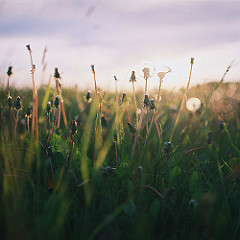

In [13]:
# Visualize an image
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.name

img = Image.open(random_image_path)

print(random_image_path)
print(image_class)
print(img.size)

img

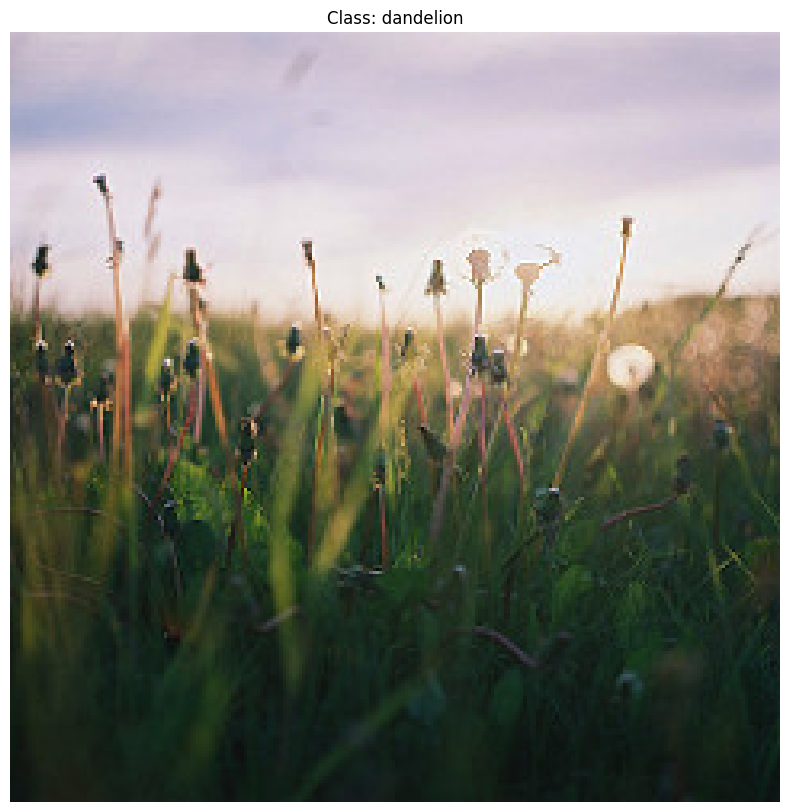

In [14]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(img)

plt.figure(figsize=(10, 10))
plt.imshow(img_as_array)
plt.title(f"Class: {image_class}")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [15]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [44]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

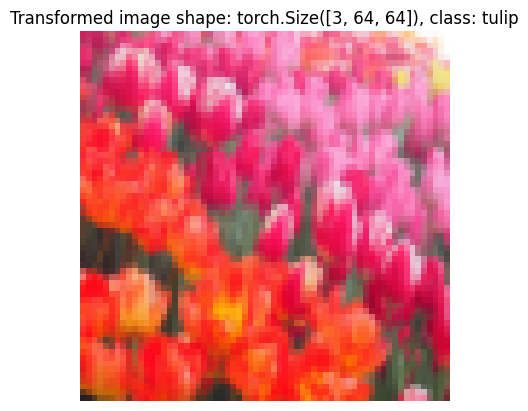

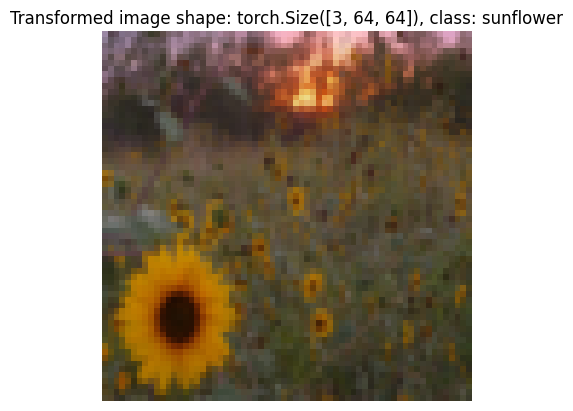

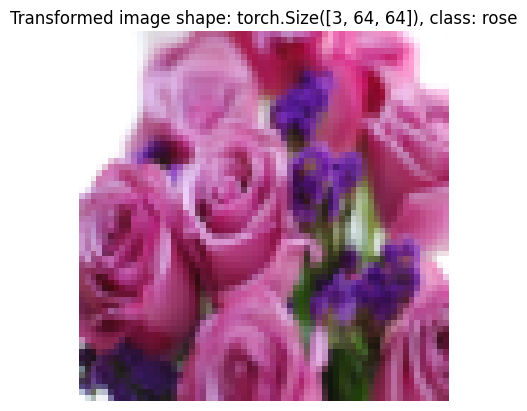

In [17]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3):
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            transformed_img = transform(img)
            plt.figure()
            plt.imshow(transformed_img.permute(1, 2, 0))  # CHW to HWC
            plt.axis(False)
            plt.title(
                f"Transformed image shape: {transformed_img.shape}, class: {image_path.parent.name}")


plot_transformed_images(image_path_list, data_transform, n=3)

### Load image data using `ImageFolder`

In [45]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
from torch.utils.data import random_split

dataset = datasets.ImageFolder(root=image_path, transform=data_transform)

split_size = int(len(dataset) * 0.8)
train_data, test_data = random_split(dataset, [split_size, len(dataset) - split_size])

print(f"Train data: {train_data} \n Test data: {test_data}")

Train data: <torch.utils.data.dataset.Subset object at 0x77fcc0d09c40> 
 Test data: <torch.utils.data.dataset.Subset object at 0x77fd2c0638c0>


In [46]:
# Get class names as a list
class_names = dataset.classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [20]:
# Can also get class names as a dict
class_dict = dataset.class_to_idx
class_dict

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [47]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(3453, 864)

In [48]:
img, label = train_data[0]
print(f"Image shape: {img.shape} | Label: {label} | Class name: {class_names[label]}")

Image shape: torch.Size([3, 128, 128]) | Label: 2 | Class name: rose


In [49]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
from os import cpu_count

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True,
                              num_workers=cpu_count(),
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64,
                             shuffle=False,
                             num_workers=cpu_count(),
                             pin_memory=True)

print(f"Train dataloader: {train_dataloader} \n Test dataloader: {test_dataloader}")

Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x77fcc08a9a90> 
 Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x77fcc08abbc0>


In [50]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(54, 14)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [25]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,  # 64 / 2 / 2 = 16
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=5, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [26]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        # Calculate and accumualte accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    # Adjust metrics to get average loss and average accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculuate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += (test_pred_class == y).sum().item() / len(test_pred)
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [36]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # Create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # Loop through the training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Train step
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        # Test step
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # Print out what's happening
        print(f"Epoch: {epoch + 1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {100.0*train_acc:.2f} % | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {100.0*test_acc:.2f} %"
              )

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the results dictionary
    return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [37]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

epochs = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0_results_5_epochs = train(model=model_0,
                                 train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6114 | train_acc: 17.64 % | test_loss: 1.6122 | test_acc: 17.63 %
Epoch: 2 | train_loss: 1.6114 | train_acc: 17.64 % | test_loss: 1.6122 | test_acc: 17.63 %
Epoch: 3 | train_loss: 1.6114 | train_acc: 17.64 % | test_loss: 1.6122 | test_acc: 17.63 %
Epoch: 4 | train_loss: 1.6114 | train_acc: 17.63 % | test_loss: 1.6122 | test_acc: 17.63 %
Epoch: 5 | train_loss: 1.6114 | train_acc: 17.64 % | test_loss: 1.6122 | test_acc: 17.63 %


In [38]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

model_0_results_20_epochs = train(model=model_0,
                                  train_dataloader=train_dataloader,
                                  test_dataloader=test_dataloader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5975 | train_acc: 24.59 % | test_loss: 1.5613 | test_acc: 28.12 %
Epoch: 2 | train_loss: 1.4968 | train_acc: 32.56 % | test_loss: 1.4507 | test_acc: 34.38 %
Epoch: 3 | train_loss: 1.3064 | train_acc: 43.67 % | test_loss: 1.2785 | test_acc: 46.21 %
Epoch: 4 | train_loss: 1.1737 | train_acc: 51.55 % | test_loss: 1.1598 | test_acc: 52.34 %
Epoch: 5 | train_loss: 1.1063 | train_acc: 54.39 % | test_loss: 1.1060 | test_acc: 57.03 %
Epoch: 6 | train_loss: 1.0763 | train_acc: 57.12 % | test_loss: 1.0696 | test_acc: 58.04 %
Epoch: 7 | train_loss: 1.0348 | train_acc: 59.34 % | test_loss: 1.0542 | test_acc: 57.03 %
Epoch: 8 | train_loss: 1.0029 | train_acc: 59.78 % | test_loss: 1.0290 | test_acc: 58.71 %
Epoch: 9 | train_loss: 0.9940 | train_acc: 61.20 % | test_loss: 1.0278 | test_acc: 59.26 %
Epoch: 10 | train_loss: 0.9760 | train_acc: 61.60 % | test_loss: 1.0344 | test_acc: 58.71 %
Epoch: 11 | train_loss: 0.9605 | train_acc: 61.84 % | test_loss: 1.0323 | test_acc: 59.04

In [39]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

model_0_results_50_epochs = train(model=model_0,
                                  train_dataloader=train_dataloader,
                                  test_dataloader=test_dataloader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8242 | train_acc: 67.80 % | test_loss: 0.9817 | test_acc: 62.95 %
Epoch: 2 | train_loss: 0.8080 | train_acc: 67.94 % | test_loss: 0.9520 | test_acc: 64.06 %
Epoch: 3 | train_loss: 0.8013 | train_acc: 68.09 % | test_loss: 0.9343 | test_acc: 64.17 %
Epoch: 4 | train_loss: 0.7882 | train_acc: 69.57 % | test_loss: 0.9311 | test_acc: 66.74 %
Epoch: 5 | train_loss: 0.7733 | train_acc: 70.43 % | test_loss: 0.9446 | test_acc: 64.51 %
Epoch: 6 | train_loss: 0.7918 | train_acc: 69.86 % | test_loss: 0.9696 | test_acc: 63.73 %
Epoch: 7 | train_loss: 0.7605 | train_acc: 71.10 % | test_loss: 0.9245 | test_acc: 64.17 %
Epoch: 8 | train_loss: 0.7530 | train_acc: 71.06 % | test_loss: 0.9514 | test_acc: 64.84 %
Epoch: 9 | train_loss: 0.7496 | train_acc: 71.28 % | test_loss: 0.9332 | test_acc: 64.96 %
Epoch: 10 | train_loss: 0.7454 | train_acc: 71.77 % | test_loss: 0.9458 | test_acc: 63.84 %
Epoch: 11 | train_loss: 0.7364 | train_acc: 71.77 % | test_loss: 1.0012 | test_acc: 63.84

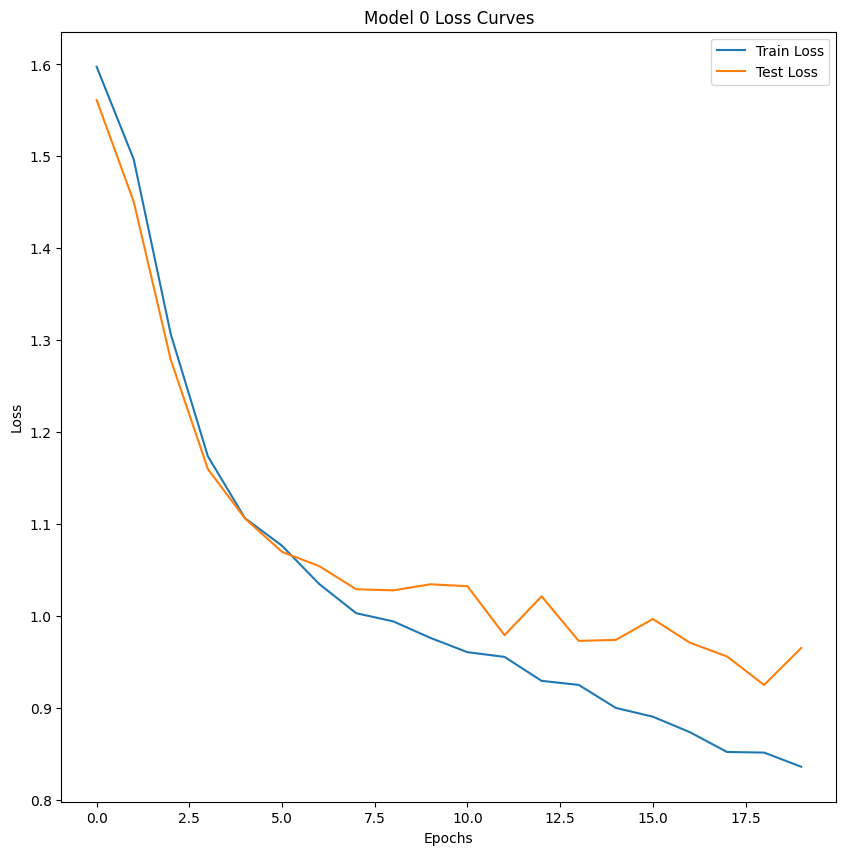

In [40]:
# 将50个epoch的结果可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(model_0_results_20_epochs["train_loss"], label="Train Loss")
plt.plot(model_0_results_20_epochs["test_loss"], label="Test Loss")
plt.title("Model 0 Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [41]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,  # Double the hidden units
                  output_shape=len(class_names)).to(device)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6096 | train_acc: 13.64 % | test_loss: 1.6097 | test_acc: 14.17 %
Epoch: 2 | train_loss: 1.6097 | train_acc: 13.38 % | test_loss: 1.6097 | test_acc: 14.84 %
Epoch: 3 | train_loss: 1.6097 | train_acc: 13.08 % | test_loss: 1.6097 | test_acc: 13.62 %
Epoch: 4 | train_loss: 1.6097 | train_acc: 13.61 % | test_loss: 1.6097 | test_acc: 15.40 %
Epoch: 5 | train_loss: 1.6097 | train_acc: 13.30 % | test_loss: 1.6097 | test_acc: 15.07 %
Epoch: 6 | train_loss: 1.6097 | train_acc: 13.07 % | test_loss: 1.6097 | test_acc: 14.73 %
Epoch: 7 | train_loss: 1.6097 | train_acc: 12.97 % | test_loss: 1.6097 | test_acc: 14.62 %
Epoch: 8 | train_loss: 1.6097 | train_acc: 13.61 % | test_loss: 1.6097 | test_acc: 14.62 %
Epoch: 9 | train_loss: 1.6097 | train_acc: 13.38 % | test_loss: 1.6097 | test_acc: 14.17 %
Epoch: 10 | train_loss: 1.6097 | train_acc: 12.89 % | test_loss: 1.6097 | test_acc: 14.51 %
Epoch: 11 | train_loss: 1.6097 | train_acc: 12.98 % | test_loss: 1.6097 | test_acc: 14.06

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get(
        "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images...

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [57]:
class AlexNet(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=4,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units * 3,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=hidden_units * 3,
                      out_channels=hidden_units * 6,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 6,
                      out_channels=hidden_units * 6,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 6,
                      out_channels=hidden_units * 3,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=9600,
                      out_features=hidden_units * 2 * 5 * 5),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units * 2 * 5 * 5,
                      out_features=hidden_units * 3 * 3),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units * 3 * 3,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# from torchinfo import summary

model_2 = AlexNet(input_shape=3,
                  hidden_units=128,
                  output_shape=len(class_names)).to(device)

# summary(model_2, (3,64,64))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01,
                            momentum=0.9)

# X = torch.randn(1, 3, 64, 64)
# for layer in AlexNet(input_shape=3, hidden_units=64, output_shape=200).features:
#     X=layer(X)
#     print(layer.__class__.__name__,'output shape:\t',X.shape)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6039 | train_acc: 22.70 % | test_loss: 1.5992 | test_acc: 26.67 %
Epoch: 2 | train_loss: 1.5989 | train_acc: 23.83 % | test_loss: 1.5987 | test_acc: 26.67 %
Epoch: 3 | train_loss: 1.5983 | train_acc: 23.82 % | test_loss: 1.5990 | test_acc: 26.67 %
Epoch: 4 | train_loss: 1.5976 | train_acc: 26.64 % | test_loss: 1.5988 | test_acc: 31.14 %
Epoch: 5 | train_loss: 1.5966 | train_acc: 27.50 % | test_loss: 1.5975 | test_acc: 33.37 %
Epoch: 6 | train_loss: 1.5947 | train_acc: 27.27 % | test_loss: 1.5933 | test_acc: 32.70 %
Epoch: 7 | train_loss: 1.5890 | train_acc: 28.67 % | test_loss: 1.5804 | test_acc: 30.02 %
Epoch: 8 | train_loss: 1.5497 | train_acc: 29.07 % | test_loss: 1.4770 | test_acc: 32.48 %
Epoch: 9 | train_loss: 1.4729 | train_acc: 31.34 % | test_loss: 1.4065 | test_acc: 37.95 %
Epoch: 10 | train_loss: 1.3727 | train_acc: 37.98 % | test_loss: 1.2904 | test_acc: 42.19 %
Epoch: 11 | train_loss: 1.2991 | train_acc: 42.34 % | test_loss: 1.2514 | test_acc: 40.85